---

# APPM 5630, Spring 2023

# Simplified Bayes vs DFOLS
<br> 

### Your name: John (Jack) Quinn

<br> 

---

Some useful packages and libraries:



In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import stats
import scipy.io
import pandas as pd
import math
import scipy
import random
import cvxpy as cvx
import pickle
import scipy.sparse, scipy.fftpack
import numpy as np
from scipy.interpolate import CloughTocher2DInterpolator
import scipy
from scipy.stats import norm

import matplotlib.pyplot as plt

Testing Alex's Code:

In [66]:
rng = np.random.default_rng(20230416)
def cov_from_kernel(x, k):
    n = x.shape[0]
    cov = np.zeros((n, n))
    for i in range(n):
        xi = x[i]
        for j in range(i, n):
            xj = x[j]
            cov[i, j] = k(xi, xj)
    c1 = cov + cov.T
    c2 = c1 - np.eye(n)
    return c2

def cov_from_kernel1(x, y, k):
    n = x.shape[0]
    nstar = y.shape[0]
    cov = np.zeros((n, nstar))

    for i in range(n):
        xi = x[i]
        for j in range(nstar):
            yj = y[j]
            cov[i, j] = k(xi, yj)
    
    return cov

def matern_52(x, x_prime, l):
    """
    this will be matern assuming that nu = 5/2
    """
    if x.shape:
        r = np.linalg.norm(x - x_prime)
    else:
        r = np.abs(x - x_prime)
    c = 1 + np.sqrt(5)*r/l + (5*r**2)/(3*l**2)
    e = np.exp(-np.sqrt(5)*r/l)
    return c*e

In [67]:

def r1(x, y):
    return -1*x**2 - 3*y**2 - 4

def r2(x, y):
    return -2.5*x**2 - 1.5*y**2 - 8

def get_mean_and_sigma(test_x, train_x, train_f, k):
    k_x_x = cov_from_kernel(train_x, k)
    k_x_xstar = cov_from_kernel1(train_x, test_x, k)
    k_xstar_xstar = cov_from_kernel(test_x, k)

    kxx_inv = np.linalg.inv(k_x_x)

    m1 = k_x_xstar.T @kxx_inv @ train_f
    cov1 = k_x_xstar.T@kxx_inv@k_x_xstar
    cov = k_xstar_xstar - cov1

    var = np.diagonal(cov)
    sigma = np.sqrt(var)
    return m1, sigma

def expected_improvement(train_f, mu, sigma, xi=0.01):

    # Calculate the current best value f(x+) observed so far
    f_best = np.max(train_f)

    # Calculate the expected improvement
    with np.errstate(divide='ignore'):
        imp = mu - f_best - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [68]:

def plot_ei(test_x, ei):
    xbase = np.linspace(-4, 4, 100)
    ybase = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(xbase, ybase)

    interp = CloughTocher2DInterpolator(test_x, ei)
    Z = interp(X, Y)

    plt.pcolormesh(X, Y, Z, shading='auto')
    plt.plot(test_x[:, 0], test_x[:, 1], 'ok', label = 'input point')
    plt.legend()
    plt.colorbar()
    plt.show()

def test_2d(samp=20,verb=False):

    x = 8 * rng.random(20) - 4
    y = 8 * rng.random(20) - 4

    r1z = r1(x, y)
    r2z = r2(x, y)
    z = lambda x, y: r1(x, y) + r2(x, y)

    rz = z(x, y)

    eval_r1 = lambda x: r1(x[:, 0], x[:, 1])
    eval_r2 = lambda x: r2(x[:, 0], x[:, 1])
    eval_z = lambda x: z(x[:, 0], x[:, 1])

    pts = list(zip(x, y))
    train_x = np.array(pts)
    train_f = rz
    # train_f = r1z
    #train_f = r2z
    m52 = lambda x, y: matern_52(x, y, 1)

    sampler = scipy.stats.qmc.LatinHypercube(2)

    test_pts = []

    for i in range(samp):
        test_x = 8 * sampler.random(100) - 4

        m1, sigma = get_mean_and_sigma(test_x, train_x, train_f, m52)

        ei = expected_improvement(train_f, m1, sigma)
        if verb:
            plot_ei(test_x, ei)

        new_x = test_x[np.argmax(ei)]
        nx = (new_x[0], new_x[1])
        pts.append(nx)
        train_x = np.array(pts)
        train_f = eval_z(train_x)
        #train_f = eval_r1(train_x)
        #train_f = eval_r2(train_x)

        test_pts.append(nx)

    tp = np.array(test_pts)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    xbase = np.linspace(-4, 4, 100)
    ybase = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(xbase, ybase)
    l1 = ax.contourf(X, Y, z(X, Y))
    #l1 = ax.contourf(X, Y, r1(X, Y))
    #l1 = ax.contourf(X, Y, r2(X, Y))
    fig.colorbar(l1)
    ax.scatter(tp[:, 0], tp[:, 1], c='red')
    f_to_ret=eval_z(tp)
    return f_to_ret,tp,len(f_to_ret),np.max(f_to_ret)

In [69]:
#!pip install DFO-LS
import dfols

In [70]:
x0=np.random.random(2)
def objfun2(x):
    return np.array([np.sqrt(1*x[0]**2 + 3*x[1]**2 +4), np.sqrt(2.5*x[0]**2 + 1.5*x[1]**2 + 8)])
print(objfun2(x0))
user_params = {'logging.save_diagnostic_info': True,'logging.save_xk': True}
soln_weird = dfols.solve(objfun2, x0, maxfun=20,user_params=user_params)
print(soln_weird)


[2.0552285  2.85684362]
****** DFO-LS Results ******
Solution xmin = [-0.000332    0.00255296]
Residual vector = [2.00000492 2.8284289 ]
Objective value f(xmin) = 12.00002972
Needed 20 objective evaluations (at 20 points)
Approximate Jacobian = [[0.00157782 0.00251502]
 [0.00123319 0.00014382]]
Diagnostic information available; check self.diagnostic_info
Exit flag = 1
Warning (max evals): Objective has been called MAXFUN times
****************************



In [71]:
#print(soln_weird.diagnostic_info)
df=soln_weird.diagnostic_info
df.head()


,xk,fk,rho,delta,interpolation_error,interpolation_condition_number,interpolation_change_J_norm,interpolation_total_residual,poisedness,max_distance_xk,...,nruns,nf,nx,npt,nsamples,iter_this_run,iters_total,iter_type,ratio,slow_iter
0,"[0.15743790320526785, 0.25766740699328217]",12.385520,0.1,0.1,2.761013e-30,3.732051,0.718315,0.215647,2.414214,0.100000,...,0,3,3,3,3,0,0,Successful,0.693777,0.0
1,"[0.11080878045306611, 0.16920427958213924]",12.171810,0.1,0.1,1.972152e-31,4.113119,0.300719,0.162921,1.601557,0.194146,...,0,4,4,3,3,1,1,Successful,0.506239,0.0
2,"[0.06999113659394812, 0.07791397369049374]",12.044463,0.1,0.1,7.888609e-31,16.554230,0.601017,0.047143,2.751903,0.259707,...,0,5,5,3,3,2,2,Successful,0.120023,0.0
3,"[-0.028117161022864823, 0.05855520465083486]",12.018196,0.1,0.1,7.888609e-31,9.358883,0.588726,0.013307,2.224566,0.177605,...,0,6,6,3,3,3,3,Acceptable (geom not fixed),0.056253,0.0
4,"[-0.02761267336047815, -0.04144352280206076]",12.010398,0.1,0.1,1.577722e-30,5.930780,0.470136,0.000878,2.018281,0.154184,...,0,7,7,3,3,4,4,Unsuccessful (geom not fixed),-2.483669,-1.0


In [72]:
print(df.columns.values.tolist())

['xk', 'fk', 'rho', 'delta', 'interpolation_error', 'interpolation_condition_number', 'interpolation_change_J_norm', 'interpolation_total_residual', 'poisedness', 'max_distance_xk', 'norm_gk', 'norm_sk', 'nruns', 'nf', 'nx', 'npt', 'nsamples', 'iter_this_run', 'iters_total', 'iter_type', 'ratio', 'slow_iter']


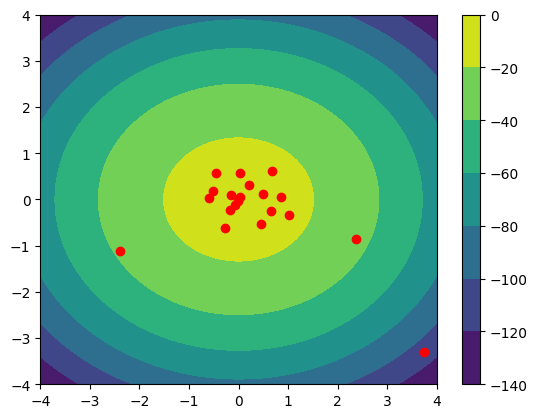

In [73]:
fvals,tp,numf,maxf=test_2d(20)

[ 3.74456985e+00  2.05891330e-01  2.99011647e-02 -5.06617906e-01
  1.01578619e+00 -2.38372097e+00  3.63982033e-02  2.36675101e+00
 -2.68854910e-01  8.48223815e-01 -2.70336459e-03  4.53063070e-01
 -6.61500130e-02 -1.62544953e-01 -4.64230479e-01 -1.71502872e-01
  6.76034667e-01  6.50648801e-01 -5.94986371e-01  4.93228035e-01]
[0.15743790320526785, 0.11080878045306611, 0.06999113659394812, -0.028117161022864823, -0.02761267336047815, -0.02761267336047815, -0.02761267336047815, -0.02761267336047815, -0.026970184273189667, -0.01778012374457814, -0.014182726307752698, -0.006686686677406184, -0.008287677495838239, 0.0004255669540096981, 0.0004255669540096981, 0.0004255669540096981, 0.0004255669540096981, -0.0003319957627839089]


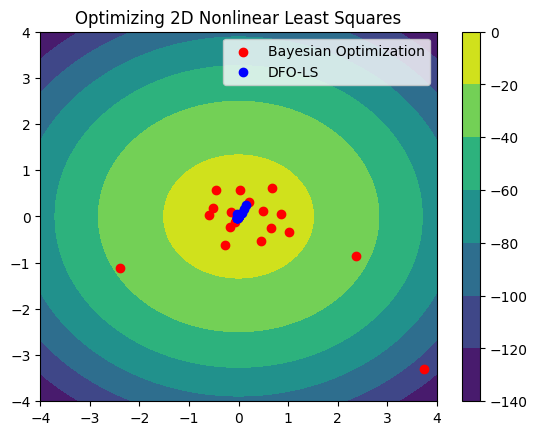

In [74]:
dfols_out = df['xk'].to_numpy()
df_x=[]
df_y=[]
for i in range(len(dfols_out)):
    df_x.append(dfols_out[i][0])
    df_y.append(dfols_out[i][1])
dfols_out=dfols_out.T#list(dfols_out)
z = lambda x, y: r1(x, y) + r2(x, y)
fig = plt.figure()
ax = fig.add_subplot(111) 
xbase = np.linspace(-4, 4, 100)
ybase = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(xbase, ybase)
l1 = ax.contourf(X, Y, z(X, Y))
ax.scatter(tp[:, 0], tp[:, 1], c='red',label="Bayesian Optimization")
print(tp[:, 0])
print(df_x)
ax.scatter(df_x,df_y, c='blue',label="DFO-LS")
fig.colorbar(l1)
ax.legend()
ax.set_title("Optimizing 2D Nonlinear Least Squares")
plt.savefig("contour_baayes_vs_dfo.png")


24.003479078949074


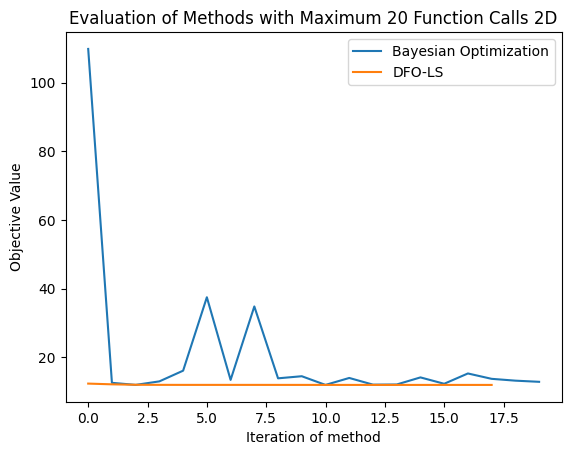

In [75]:
plt.plot(np.abs(fvals),label="Bayesian Optimization")
plt.plot(df["fk"],label="DFO-LS")
plt.legend()
plt.title("Evaluation of Methods with Maximum 20 Function Calls 2D")
plt.xlabel("Iteration of method")
plt.ylabel("Objective Value")
plt.savefig("comparing_methods_dim2.png")
print(np.abs(maxf-soln_weird.f))


## Higher dimensional Implementation

In [89]:
def z_func(x,dim=2):
    out=np.zeros(len(x))
    #print(len(out))
    multer=np.arange(dim)+1
    bias = multer+2
    for i in range(dim):
        out-=np.sum((multer+i)*x**2+bias+i,axis=1)
    return out
def z_func_resid(x,dim=2):
    out=[]
    multer=np.arange(dim)+1
    bias = multer+2
    for i in range(dim):
        out.append(np.sqrt(np.sum((multer+i)*x**2+bias+i)))
    return np.array(out)
def test_high_d(samp=20,verb=False,dim=2,z=z_func):

    x = 8 * rng.random((20,dim)) - 4
    #print(x)
    #x=x.T
    rz = z(x,dim)

    eval_z = lambda x: z(x,dim)

    pts = list(x)
    train_x = np.array(pts)
    train_f = rz
    #print(train_f)
    m52 = lambda x, y: matern_52(x, y, 1)

    sampler = scipy.stats.qmc.LatinHypercube(dim)

    test_pts = []
    f_to_ret=[]
    for i in range(samp):
        test_x = 8 * sampler.random(100) - 4

        m1, sigma = get_mean_and_sigma(test_x, train_x, train_f, m52)

        ei = expected_improvement(train_f, m1, sigma)
        if verb:
            plot_ei(test_x, ei)

        new_x = test_x[np.argmax(ei)]
        #nx = (new_x[0], new_x[1])
        pts.append(new_x)
        train_x = np.array(pts)
        train_f = eval_z(train_x)

        test_pts.append(new_x)
        #f_to_ret.append(eval_z(new_x))
        
    tp = np.array(test_pts)
    f_to_ret=eval_z(tp)
    return f_to_ret,tp,len(f_to_ret),np.max(f_to_ret)

In [90]:
f_to_ret,tp,len_f_to_ret,max_f_to_ret = test_high_d(samp=20,verb=False,dim=5,z=z_func)

In [91]:
user_params = {'logging.save_diagnostic_info': True}
x0 = np.ones(5)
z_with_dim = lambda x: z_func_resid(x,5)
soln_weird = dfols.solve(z_with_dim, x0, maxfun=20,user_params=user_params)
#print(soln_weird)
df=soln_weird.diagnostic_info

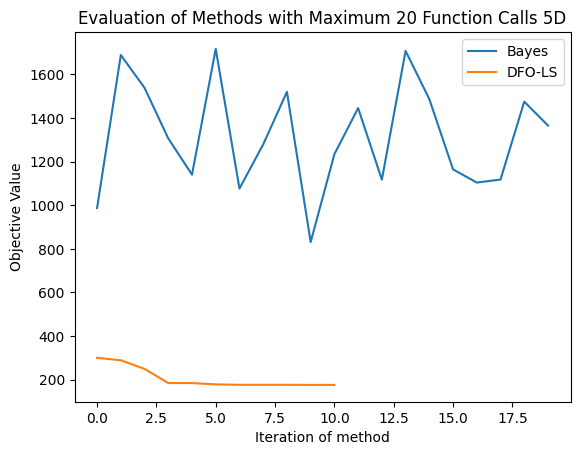

In [92]:
plt.plot(np.abs(f_to_ret),label="Bayes")
plt.plot(df["fk"],label="DFO-LS")
plt.legend()
plt.title("Evaluation of Methods with Maximum 20 Function Calls 5D")
plt.xlabel("Iteration of method")
plt.ylabel("Objective Value")
plt.savefig("comparing_methods_dim5.png")
#print(np.abs(maxf-soln_weird.f))

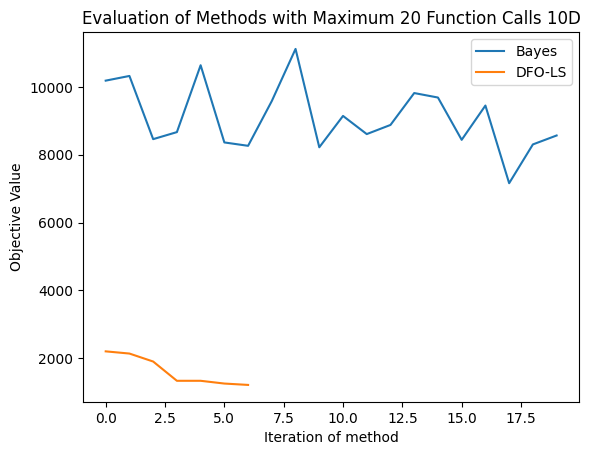

In [93]:
f_to_ret,tp,len_f_to_ret,max_f_to_ret = test_high_d(samp=20,verb=False,dim=10,z=z_func)
user_params = {'logging.save_diagnostic_info': True}
x0 = np.ones(10)
z_with_dim = lambda x: z_func_resid(x,10)
soln_weird = dfols.solve(z_with_dim, x0, maxfun=20,user_params=user_params)
#print(soln_weird)
df=soln_weird.diagnostic_info
plt.plot(np.abs(f_to_ret),label="Bayes")
plt.plot(df["fk"],label="DFO-LS")
plt.legend()
plt.title("Evaluation of Methods with Maximum 20 Function Calls 10D")
plt.xlabel("Iteration of method")
plt.ylabel("Objective Value")
plt.savefig("comparing_methods_dim10.png")

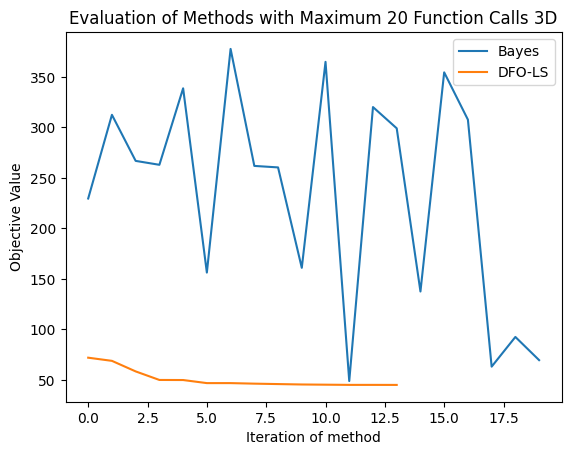

In [95]:
f_to_ret,tp,len_f_to_ret,max_f_to_ret = test_high_d(samp=20,verb=False,dim=3,z=z_func)
user_params = {'logging.save_diagnostic_info': True}
x0 = np.ones(3)
z_with_dim = lambda x: z_func_resid(x,3)
soln_weird = dfols.solve(z_with_dim, x0, maxfun=20,user_params=user_params)
#print(soln_weird)
df=soln_weird.diagnostic_info
plt.plot(np.abs(f_to_ret),label="Bayes")
plt.plot(df["fk"],label="DFO-LS")
plt.legend()
plt.title("Evaluation of Methods with Maximum 20 Function Calls 3D")
plt.xlabel("Iteration of method")
plt.ylabel("Objective Value")
plt.savefig("comparing_methods_dim3.png")

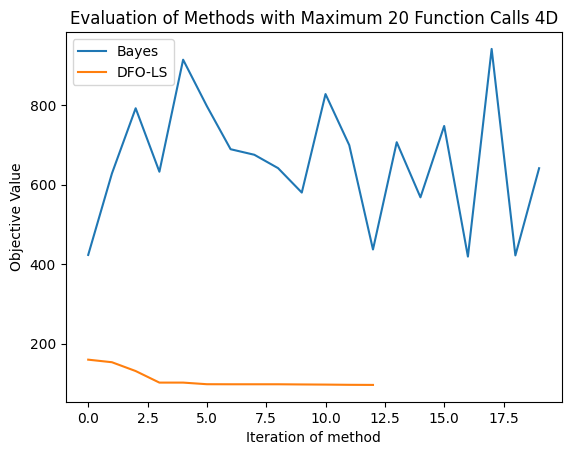

In [96]:
f_to_ret,tp,len_f_to_ret,max_f_to_ret = test_high_d(samp=20,verb=False,dim=4,z=z_func)
user_params = {'logging.save_diagnostic_info': True}
x0 = np.ones(4)
z_with_dim = lambda x: z_func_resid(x,4)
soln_weird = dfols.solve(z_with_dim, x0, maxfun=20,user_params=user_params)
#print(soln_weird)
df=soln_weird.diagnostic_info
plt.plot(np.abs(f_to_ret),label="Bayes")
plt.plot(df["fk"],label="DFO-LS")
plt.legend()
plt.title("Evaluation of Methods with Maximum 20 Function Calls 4D")
plt.xlabel("Iteration of method")
plt.ylabel("Objective Value")
plt.savefig("comparing_methods_dim4.png")